In [1]:
import GCRCatalogs
from clevar import ClCatalog, MemCatalog
from clevar.match import MembershipMatch, get_matched_pairs
from clevar.match import output_matched_catalog
import clevar
clevar.__version__

'0.13.5'

In [2]:
import sys
sys.path.append('../')
from cluster_validation.mass_richness_functions import *


In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib 

matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'figure.figsize': (10,8)})

# 1 - opening catalogs

In [4]:
gc_truth = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image' )

In [5]:
cosmo = gc_truth.cosmology

In [6]:
min_richness = 5
min_halo_mass = 1e13 #Msun

### match with MFoF cut

In [7]:
RM_cat = ClCatalog.read('RM_cat_richness_min_'+str(min_richness)+'.fits', name='RM_cat', full=True)

In [8]:
halo_cat = ClCatalog.read('halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'.fits', name='halo_cat', full=True)

In [9]:
#RM_cat.read_members('RM_cat_richness_min_'+str(min_richness)+'_members.fits',  full=True)

In [10]:
#halo_cat.read_members('halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'_members.fits', full=True)

### match with M200c cut

In [11]:
RM_cat_m200 = ClCatalog.read('../v0/c1.fits', name='RM_cat', full=True)

In [12]:
halo_cat_m200 = ClCatalog.read('../v0/c2.fits', name='halo_cat', full=True)

# 2 - associate redMaPPer detections to true DC2 halos

### match with MFoF cut

In [13]:
RM_cat._init_match_vals(True)
halo_cat._init_match_vals(True)

In [14]:
mt = MembershipMatch()

In [15]:
mt.load_matches(RM_cat, halo_cat, out_dir='cosmoDC2_RM_match_cross_membership')

RM_cat
    * ClEvar used in matching: 0.13.5
 * Total objects:    45,081
 * multiple (self):  43,211
 * multiple (other): 43,211
 * unique (self):    42,973
 * unique (other):   42,825
 * cross:            42,754

halo_cat
    * ClEvar used in matching: 0.13.5
 * Total objects:    278,904
 * multiple (self):  75,514
 * multiple (other): 75,514
 * unique (self):    42,825
 * unique (other):   42,973
 * cross:            42,754


In [16]:
RM_cat_bij, halo_cat_bij = get_matched_pairs(RM_cat, halo_cat, 'cross')

In [17]:
#version with SkySim M200c information added manually
halo_cat_bij_ss = ClCatalog.read_full('cosmoDC2_RM_match_cross_membership/halo_cat_bij_ss.fits')

    * ClEvar used in matching: 0.13.5


In [18]:
RM_cat_bij.size, RM_cat_bij.size/RM_cat.size,  halo_cat_bij_ss.size/halo_cat.size

(42754, 0.9483818016459262, 0.15329288930958324)

In [70]:
output_matched_catalog('cosmoDC2_RM_match_cross_membership/RM_cat_bij.fits', 'cosmoDC2_RM_match_cross_membership/halo_cat_bij_ss.fits',
                       'cosmoDC2_RM_match_cross_membership/matched_pairs_Mfofcut.fits', RM_cat_bij, halo_cat_bij, matching_type='cross')

### match with M200c cut

In [19]:
RM_cat_m200._init_match_vals(True)
halo_cat_m200._init_match_vals(True)

In [20]:
mt_m200 = MembershipMatch()

In [21]:
mt_m200.load_matches(RM_cat_m200, halo_cat_m200, out_dir='../v0')

RM_cat
    * ClEvar used in matching: <0.13.0
 * Total objects:    45,081
 * multiple (self):  42,643
 * multiple (other): 42,643
 * unique (self):    42,643
 * unique (other):   42,291
 * cross:            42,045

halo_cat
    * ClEvar used in matching: <0.13.0
 * Total objects:    454,475
 * multiple (self):  72,391
 * multiple (other): 72,391
 * unique (self):    72,391
 * unique (other):   42,173
 * cross:            42,045


In [22]:
RM_cat_bij_m200, halo_cat_bij_m200 = get_matched_pairs(RM_cat_m200, halo_cat_m200, 'cross')

In [23]:
RM_cat_bij_m200.size, RM_cat_bij_m200.size/RM_cat_m200.size,  halo_cat_bij_m200.size/halo_cat_m200.size

(42045, 0.932654555134092, 0.09251333956763298)

In [46]:
RM_cat_bij_m200.write('../v0/RM_cat_bij_m200.fits', overwrite=True)

In [47]:
halo_cat_bij_m200.write('../v0/halo_cat_bij_m200.fits', overwrite=True)

In [68]:
output_matched_catalog('../v0/RM_cat_bij_m200.fits', '../v0/halo_cat_bij_m200.fits',
                       '../v0/matched_pairs_M200cut.fits', RM_cat_bij_m200, halo_cat_bij_m200, matching_type='cross')

### Joined catalog comparison

# 3 - Analyse mass richness relation

### Matched performed with halo Mfof > 1e13

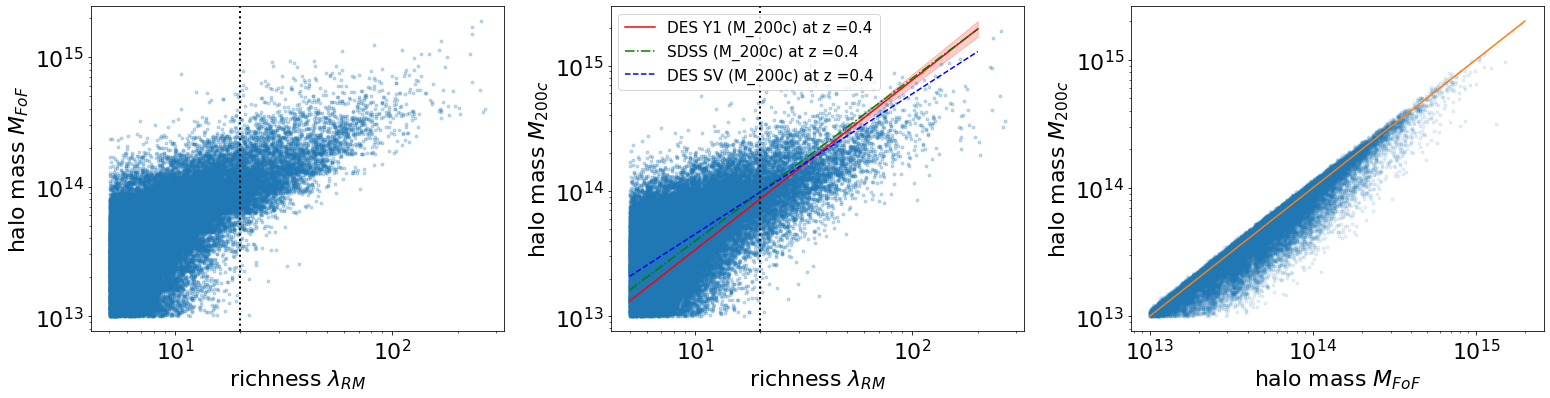

In [48]:
#adding parametrization from litterature
ll = np.logspace(np.log10(min_richness), np.log10(200))
z0 = 0.4
Om_z0 = cosmo.Om0   


fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(22,6))

ax1.loglog(RM_cat_bij['richness'], halo_cat_bij_ss['mass_fof'], '.',alpha=0.25)
ax1.set_xlabel("richness $\\lambda_{RM}$")
ax1.set_ylabel('halo mass $M_{FoF}$')
ax1.axvline(20, color='black', linestyle='dotted', lw=2)

ax2.loglog(RM_cat_bij['richness'], halo_cat_bij_ss['M200c'], '.',alpha=0.25)
ax2.set_xlabel("richness $\\lambda_{RM}$")
ax2.set_ylabel('halo mass $M_{200c}$')
ax2.axvline(20, color='black', linestyle='dotted', lw=2)
ax2.fill_between(ll, M_DES_Y1_lim(ll, z0, 'min', Om_z0),M_DES_Y1_lim(ll, z0, 'max', Om_z0),alpha=0.2,color='r')
ax2.plot(ll, M_DES_Y1(ll, z0, Om_z0), 'r-', alpha=1, label='DES Y1 (M_200c) at z ='+str(z0) )
ax2.plot(ll, M_SDSS(ll, z0, Om_z0), 'g-.', alpha=1, label='SDSS (M_200c) at z ='+str(z0))
ax2.plot(ll, M_DES_SV(ll, z0, Om_z0), 'b--', alpha=1, label='DES SV (M_200c) at z ='+str(z0))
ax2.legend(fontsize='x-small')

ax3.loglog(halo_cat_bij_ss['mass_fof'], halo_cat_bij_ss['M200c'], '.',alpha=0.1)
ax3.set_xlabel('halo mass $M_{FoF}$')
ax3.set_ylabel('halo mass $M_{200c}$')
ax3.plot((1e13,2e15),(1e13,2e15))

fig.tight_layout()

### Matched performed with halo M200c > 1e13 (beta version)

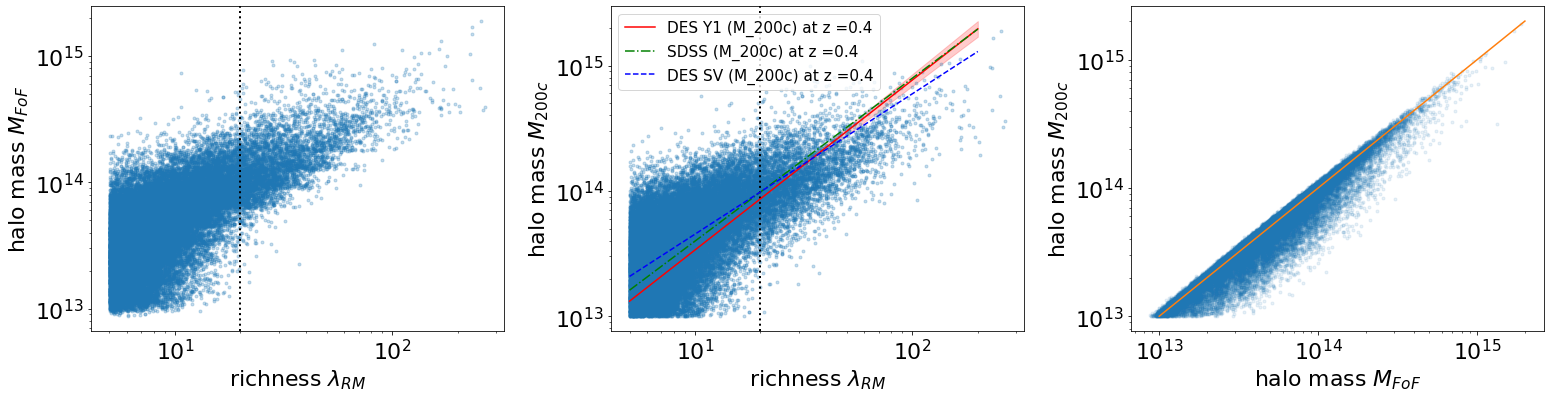

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(22,6))

ax1.loglog(RM_cat_bij_m200['mass'], halo_cat_bij_m200['mass'], '.',alpha=0.25)
ax1.set_xlabel("richness $\\lambda_{RM}$")
ax1.set_ylabel('halo mass $M_{FoF}$')
ax1.axvline(20, color='black', linestyle='dotted', lw=2)

ax2.loglog(RM_cat_bij_m200['mass'], halo_cat_bij_m200['M200c'], '.',alpha=0.25)
ax2.set_xlabel("richness $\\lambda_{RM}$")
ax2.set_ylabel('halo mass $M_{200c}$')
ax2.axvline(20, color='black', linestyle='dotted', lw=2)
ax2.fill_between(ll, M_DES_Y1_lim(ll, z0, 'min', Om_z0),M_DES_Y1_lim(ll, z0, 'max', Om_z0),alpha=0.2,color='r')
ax2.plot(ll, M_DES_Y1(ll, z0, Om_z0), 'r-', alpha=1, label='DES Y1 (M_200c) at z ='+str(z0) )
ax2.plot(ll, M_SDSS(ll, z0, Om_z0), 'g-.', alpha=1, label='SDSS (M_200c) at z ='+str(z0))
ax2.plot(ll, M_DES_SV(ll, z0, Om_z0), 'b--', alpha=1, label='DES SV (M_200c) at z ='+str(z0))
ax2.legend(fontsize='x-small')

ax3.loglog(halo_cat_bij_m200['mass'], halo_cat_bij_m200['M200c'], '.',alpha=0.1)
ax3.set_xlabel('halo mass $M_{FoF}$')
ax3.set_ylabel('halo mass $M_{200c}$')
ax3.plot((1e13,2e15),(1e13,2e15))

fig.tight_layout()

## Fit of the relation

### Matched performed with halo Mfof > 1e13

In [50]:
data_mcmc = [np.log10(halo_cat_bij_ss['M200c']), RM_cat_bij['z'], np.log10(RM_cat_bij['richness'])]
DES_limits =  (halo_cat_bij_ss['z']>0.2) * (halo_cat_bij_ss['z']<0.65) * (RM_cat_bij['richness']>20)
data_mcmc_limited = [np.log10(halo_cat_bij_ss['M200c'][DES_limits]), RM_cat_bij['z'][DES_limits], np.log10(RM_cat_bij['richness'][DES_limits])]

In [51]:
initial = [14.3,0.0,1]
pos = initial + 0.5 * np.random.randn(100, len(initial))
Nit = 500
#labels = [r'$\log_{10}(M_{\rm FoF,0})$', r'$G_z^\mu$', r'$G_\lambda^\mu$']
labels = [r'$\log_{10}(M_{\rm 200c,0})$', r'$G_z^\mu$', r'$G_\lambda^\mu$']

100%|██████████| 500/500 [02:32<00:00,  3.27it/s]


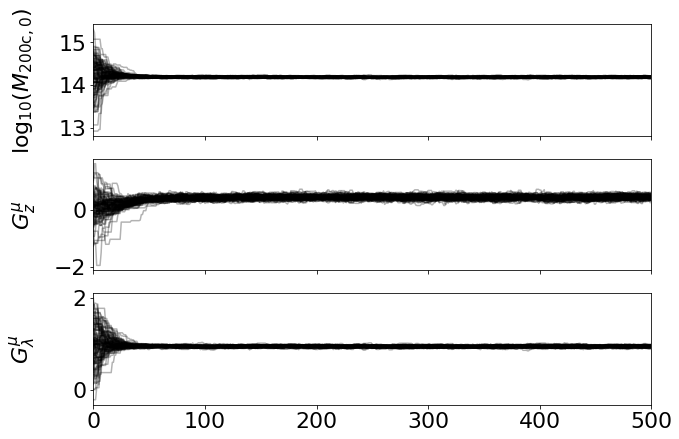

In [52]:
sampler =  sampler_prep(pos, data_mcmc)
sampler.run_mcmc(pos, Nit, progress=True);
plot_chains(labels, sampler)

100%|██████████| 500/500 [00:51<00:00,  9.75it/s]


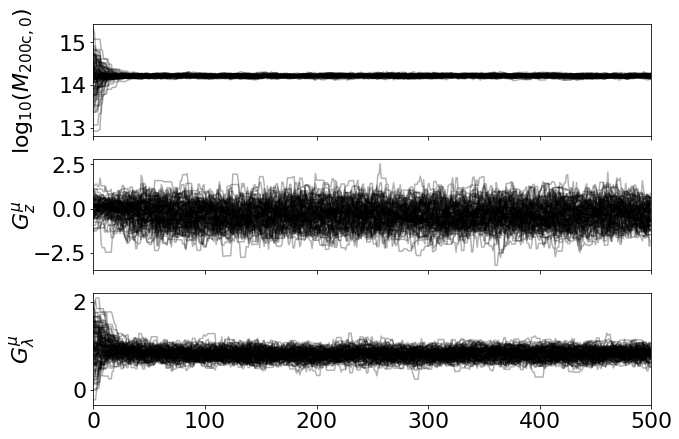

In [53]:
sampler_limited =  sampler_prep(pos, data_mcmc_limited)
sampler_limited.run_mcmc(pos, Nit, progress=True);
plot_chains(labels, sampler_limited)

In [54]:
flat_samples_cutMfof = sampler.get_chain(discard=150, thin=1, flat=True)
flat_samples_limited_cutMfof = sampler_limited.get_chain(discard=150, thin=1, flat=True)

### Matched performed with halo M200c > 1e13 (beta version)

In [55]:
data_mcmc_cutM200 = [np.log10(halo_cat_bij_m200['M200c']), RM_cat_bij_m200['z'], np.log10(RM_cat_bij_m200['mass'])]
DES_limits_cutM200 =  (halo_cat_bij_m200['z']>0.2) * (halo_cat_bij_m200['z']<0.65) * (RM_cat_bij_m200['mass']>20)
data_mcmc_limited_cutM200 = [np.log10(halo_cat_bij_m200['M200c'][DES_limits_cutM200]), RM_cat_bij_m200['z'][DES_limits_cutM200], np.log10(RM_cat_bij_m200['mass'][DES_limits_cutM200])]

100%|██████████| 500/500 [01:25<00:00,  5.86it/s]


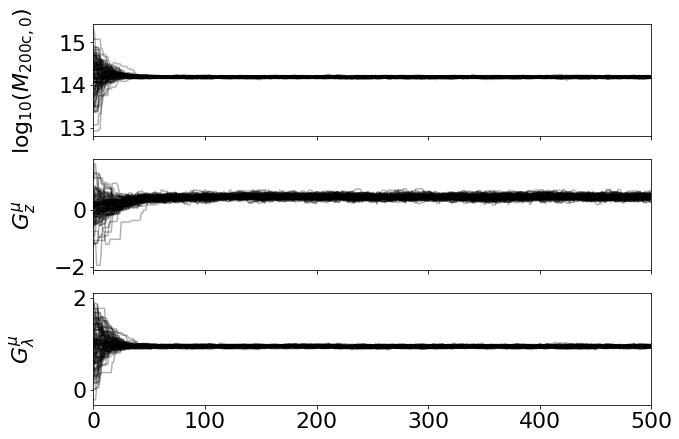

In [56]:
sampler_cutM200 =  sampler_prep(pos, data_mcmc_cutM200)
sampler_cutM200.run_mcmc(pos, Nit, progress=True);
plot_chains(labels, sampler_cutM200)

100%|██████████| 500/500 [00:29<00:00, 17.14it/s]


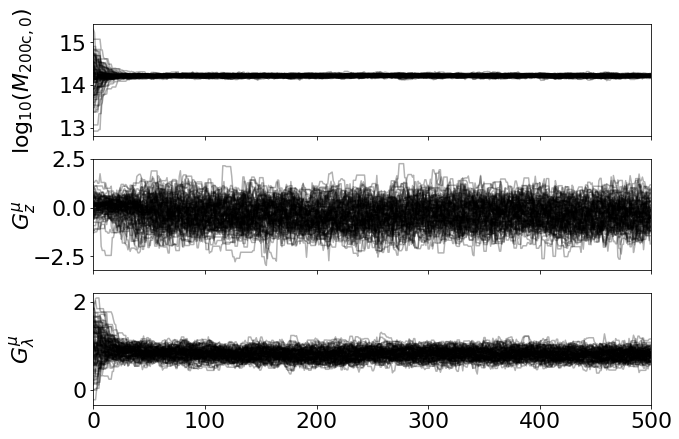

In [57]:
sampler_limited_cutM200 =  sampler_prep(pos, data_mcmc_limited_cutM200)
sampler_limited_cutM200.run_mcmc(pos, Nit, progress=True);
plot_chains(labels, sampler_limited_cutM200)

In [58]:
flat_samples_cutM200 = sampler_cutM200.get_chain(discard=150, thin=1, flat=True)
flat_samples_limited_cutM200 = sampler_limited_cutM200.get_chain(discard=150, thin=1, flat=True)

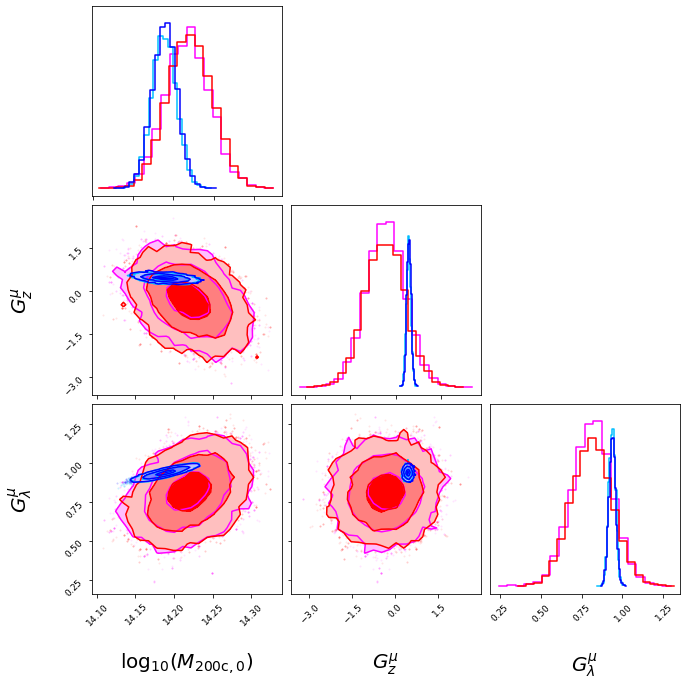

In [59]:
fig, axs = plt.subplots(len(labels), len(labels), figsize = (10,10))  
plot_corner(fig, flat_samples_limited_cutMfof, labels, bins =20)
plot_corner(fig, flat_samples_cutMfof, labels, bins =20,  color='deepskyblue')
plot_corner(fig, flat_samples_limited_cutM200, labels, bins =20,  color='red')
plot_corner(fig, flat_samples_cutM200, labels, bins =20,  color='blue')

for i in range(len(labels)):
    for j in range(len(labels)):
        axs[i,j].tick_params(axis='both', which = 'major', labelsize= 9)

In [60]:
print("Matched performed with halo Mfof > 1e13 ")
[print ("Mean    " + labels[i] + "  =", np.round(np.mean(flat_samples_cutMfof,axis=0)[i],2)) for i in range(3)];
print("\nMatched performed with halo M200c > 1e13 ")
[print ("Mean    " + labels[i] + "  =", np.round(np.mean(flat_samples_cutM200,axis=0)[i],2)) for i in range(3)];

Matched performed with halo Mfof > 1e13 
Mean    $\log_{10}(M_{\rm 200c,0})$  = 14.19
Mean    $G_z^\mu$  = 0.44
Mean    $G_\lambda^\mu$  = 0.94

Matched performed with halo M200c > 1e13 
Mean    $\log_{10}(M_{\rm 200c,0})$  = 14.19
Mean    $G_z^\mu$  = 0.45
Mean    $G_\lambda^\mu$  = 0.94


In [76]:
z0 = 0.4

mor_mean_cutMfof, mor_samples_cutMfof = MOR_from_sample(flat_samples_cutMfof, z0=z0)
mor_mean_limited_cutMfof, mor_samples_limited_cutMfof = MOR_from_sample(flat_samples_limited_cutMfof, z0=z0)
mor_mean_cutM200, mor_samples_cutM200 = MOR_from_sample(flat_samples_cutM200, z0=z0)
mor_mean_limited_cutM200, mor_samples_limited_cutM200 = MOR_from_sample(flat_samples_limited_cutM200, z0=z0)

### Relation for match performed with halo Mfof > 1e13

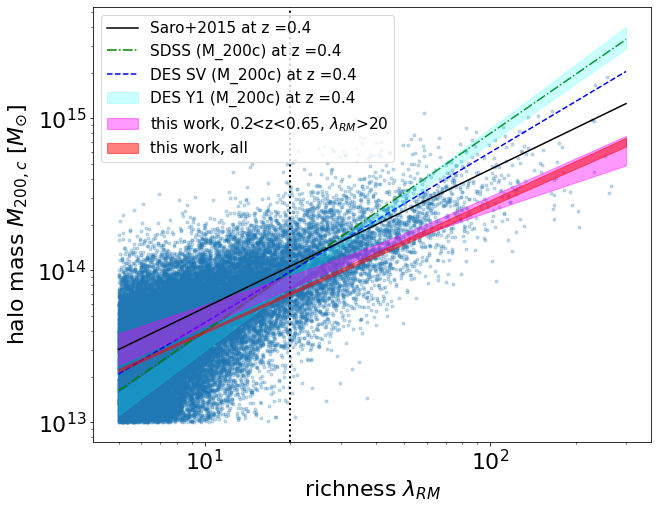

In [77]:
plt.loglog(RM_cat_bij['richness'], halo_cat_bij_ss['M200c'], '.',alpha=0.25)
plt.axvline(20, color='black', linestyle='dotted', lw=2)

plt.xlabel("richness $\\lambda_{RM}$")
plt.ylabel('halo mass $M_{200,c}$ [$M_{\odot}$]')

#adding parametrization from litterature
ll = np.logspace(np.log10(min_richness), np.log10(300))

plt.fill_between(ll, M_DES_Y1_lim(ll, z0, 'min', Om_z0),M_DES_Y1_lim(ll, z0, 'max', Om_z0),alpha=0.2, color='cyan', zorder=3, label='DES Y1 (M_200c) at z ='+str(z0) )
plt.plot(ll, M_Saro(ll, z0, Om_z0), 'k', alpha=1, zorder=3, label='Saro+2015 at z ='+str(z0))

#plt.plot(ll, M_DES_Y1(ll, z0, Om_z0), 'b-', alpha=1, label='DES Y1 (M_200c) at z ='+str(z0) )
plt.plot(ll, M_SDSS(ll, z0, Om_z0), 'g-.', alpha=1, label='SDSS (M_200c) at z ='+str(z0))
plt.plot(ll, M_DES_SV(ll, z0, Om_z0), 'b--', alpha=1, label='DES SV (M_200c) at z ='+str(z0))

#plt.plot(ll, mor_mean, lw=4)
plt.fill_between(ll, np.percentile(mor_samples_limited_cutMfof,16, axis=1) , np.percentile(mor_samples_limited_cutMfof,84, axis=1), alpha=0.4, color='magenta', zorder=3, label='this work, 0.2<z<0.65, $\\lambda_{RM}$>20')
plt.fill_between(ll, np.percentile(mor_samples_cutMfof,16, axis=1) , np.percentile(mor_samples_cutMfof,84, axis=1), alpha=0.5, color='red', zorder=3, label='this work, all')



plt.legend(fontsize='x-small')

### Relation for match performed with halo M200c > 1e13

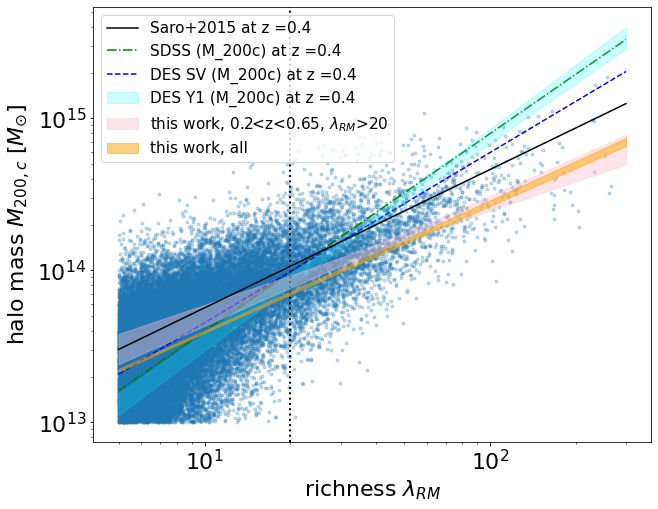

In [189]:
plt.loglog(RM_cat_bij_m200['mass'], halo_cat_bij_m200['M200c'], '.',alpha=0.25)
plt.axvline(20, color='black', linestyle='dotted', lw=2)

plt.xlabel("richness $\\lambda_{RM}$")
plt.ylabel('halo mass $M_{200,c}$ [$M_{\odot}$]')

#adding parametrization from litterature
ll = np.logspace(np.log10(min_richness), np.log10(300))

plt.fill_between(ll, M_DES_Y1_lim(ll, z0, 'min', Om_z0),M_DES_Y1_lim(ll, z0, 'max', Om_z0),alpha=0.2, color='cyan', zorder=3, label='DES Y1 (M_200c) at z ='+str(z0) )
plt.plot(ll, M_Saro(ll, z0, Om_z0), 'k', alpha=1, zorder=3, label='Saro+2015 at z ='+str(z0))

#plt.plot(ll, M_DES_Y1(ll, z0, Om_z0), 'b-', alpha=1, label='DES Y1 (M_200c) at z ='+str(z0) )
plt.plot(ll, M_SDSS(ll, z0, Om_z0), 'g-.', alpha=1, label='SDSS (M_200c) at z ='+str(z0))
plt.plot(ll, M_DES_SV(ll, z0, Om_z0), 'b--', alpha=1, label='DES SV (M_200c) at z ='+str(z0))

#plt.plot(ll, mor_mean, lw=4)
plt.fill_between(ll, np.percentile(mor_samples_limited_cutM200,16, axis=1) , np.percentile(mor_samples_limited_cutM200,84, axis=1), alpha=0.4, color='pink', zorder=3, label='this work, 0.2<z<0.65, $\\lambda_{RM}$>20')
plt.fill_between(ll, np.percentile(mor_samples_cutM200,16, axis=1) , np.percentile(mor_samples_cutM200,84, axis=1), alpha=0.5, color='orange', zorder=3, label='this work, all')



plt.legend(fontsize='x-small')